In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='SimHei'
import seaborn as sns

In [8]:
# 读取数据
data_user=pd.read_csv(r"C:\Users\60580\Documents\WeChat Files\wxid_lusqzqubjyl212\FileStorage\File\2023-04\tianchi_mobile_recommend_train_user.csv")

In [12]:
# 数据处理
data_user.isnull().sum()
# 此处的缺失值是地理位置，由于加密，故不需要删除

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
date                   0
hour                   0
dtype: int64

In [13]:
data_user.head() # behavior_type中1，2，3，4分别对应点击、收藏、加购物车、支付
# 将time这一列分为日期和小时

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [14]:
import re
data_user['date']=data_user['time'].map(lambda s:re.compile(' ').split(s)[0])
data_user['hour']=data_user['time'].map(lambda s:re.compile(' ').split(s)[1])
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [15]:
data_user.dtypes # 查看数据类型,将time，data，hour换成正确类型
# 将time，data，hour换成正确类型
data_user['time']=pd.to_datetime(data_user['time'])
data_user['date']=pd.to_datetime(data_user['date'])
data_user['hour']=data_user['hour'].astype('int64')
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

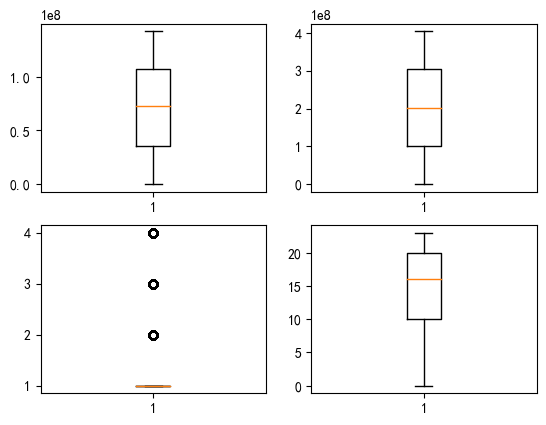

In [16]:
# 通过绘制箱线图来查看是否存在异常值
figure,ax=plt.subplots(2,2)
ax[0][0].boxplot(data_user['user_id'])
ax[0][1].boxplot(data_user['item_id'])
ax[1][0].boxplot(data_user['behavior_type'])
ax[1][1].boxplot(data_user['hour'])
plt.show() # 可以看出不存在异常值

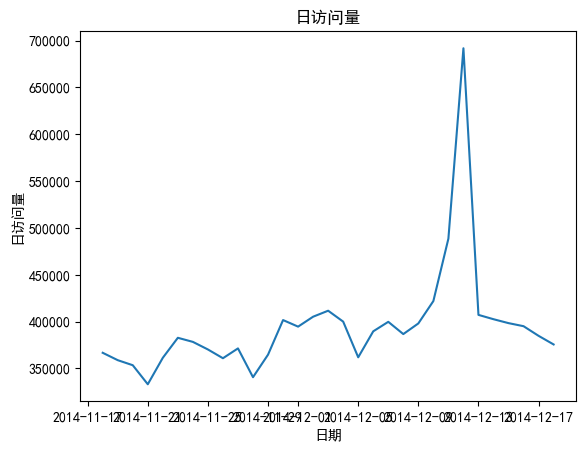

In [17]:
# 数据分析
# 分析日PV有多少，即日访问量
pv_daily=data_user.groupby(data_user['date'])['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
plt.plot(pv_daily['date'],pv_daily['pv'])
plt.xlabel('日期')
plt.ylabel('日访问量')
plt.title('日访问量')
plt.show()

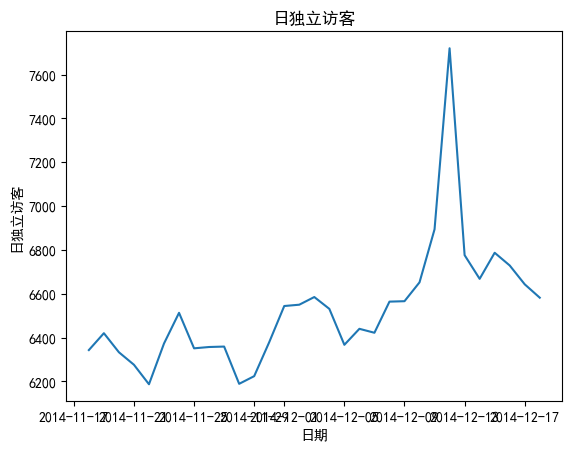

In [18]:
# 分析日UV有多少，即日独立访客，即日访问量中不重复的部分
uv_daily=data_user.groupby(data_user['date'])['user_id'].apply(lambda s:s.drop_duplicates().count()).reset_index().\
    rename(columns={'user_id':'uv'})
plt.plot(uv_daily['date'],uv_daily['uv'])
plt.xlabel('日期')
plt.ylabel('日独立访客')
plt.title('日独立访客')
plt.show()

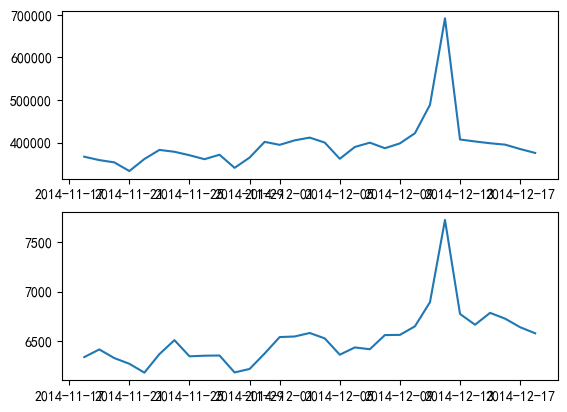

In [19]:
# 合并分析日pv和日uv
figure,ax=plt.subplots(2,1)
ax[0].plot(pv_daily['date'],pv_daily['pv'])
ax[1].plot(uv_daily['date'],uv_daily['uv'])
plt.show() # 从两幅图图中可以看到日pv和日uv都在双十二期间达到峰值，并且日pv和日uv两者之间数值相差较大

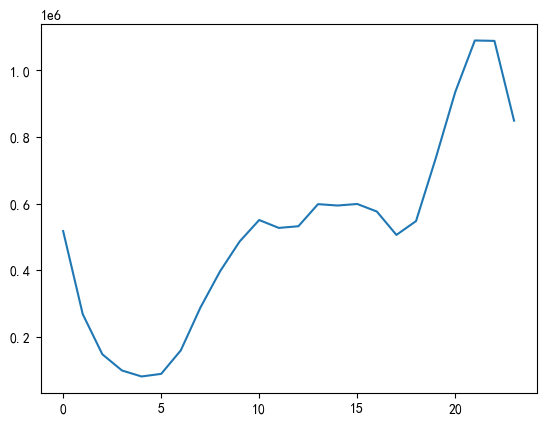

In [20]:
# 小时访问量分析
pv_hour=data_user.groupby(data_user['hour'])['user_id'].count().reset_index().rename(columns={'user_id':'hv'})
plt.plot(pv_hour['hour'],pv_hour['hv'])
plt.show() # 从图中可以看出在凌晨0-5点访问量较小，5点之和访问量开始攀升，在18点作业访问量陡升，波动较大，访问量在20点左右达到峰值

<AxesSubplot:xlabel='hour', ylabel='behavior'>

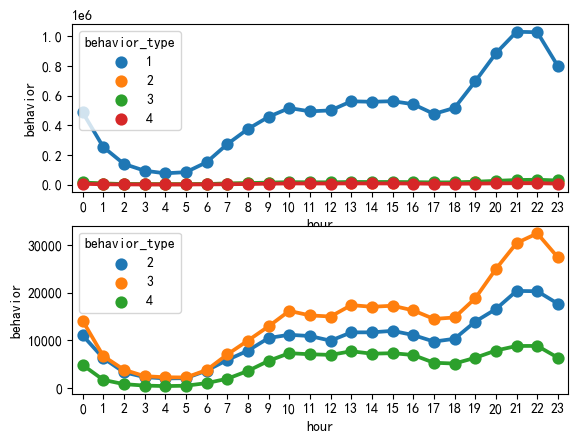

In [21]:
# 分析用户每小时行为
behavior_pv=data_user.groupby(['behavior_type','hour'])['user_id'].count().reset_index().\
    rename(columns={'user_id':'behavior'})
figure,ax=plt.subplots(2,1) # 由以下两图可以看出用户的点击行为始终是最高的，并且四种行为的波动基本一致
sns.pointplot(x='hour',y='behavior',hue='behavior_type',data=behavior_pv,ax=ax[0])
sns.pointplot(x='hour',y='behavior',hue='behavior_type',data=behavior_pv[behavior_pv.behavior_type!=1],ax=ax[1])

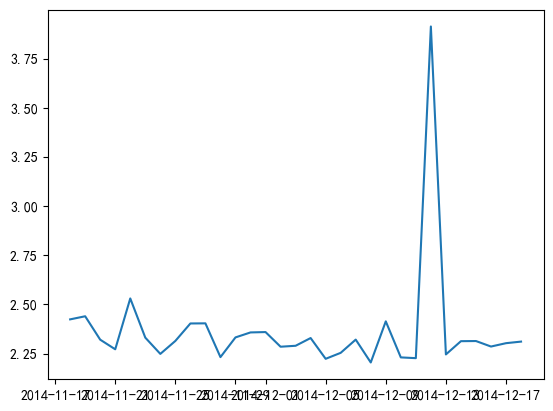

In [22]:
# 分析人均消费次数(总消费次数/消费人数)
purchase_coun=data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().\
    reset_index()
purchase_coun
aver_purchase_coun=purchase_coun.groupby('date').apply(lambda s:s.behavior_type.sum()/s.user_id.count()).reset_index().\
    rename(columns={0:'count'})
plt.plot(aver_purchase_coun['date'],aver_purchase_coun['count']) # 从图中可以看出在双十二期间人均消费次数达到最高峰，日平均消费次数在1-2次之间波动

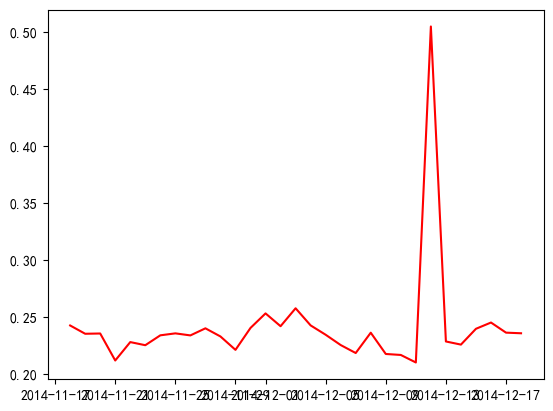

In [23]:
# 付费率分析(消费人数/活跃人数)
purchase_daily=data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().reset_index().\
    rename(columns={'behavior_type':'count'})
purchase_daily_total=purchase_daily.groupby('date').apply(lambda s:s.user_id.count()).reset_index().\
    rename(columns={0:'count'})
purchase_daily_total['purchase_per']=purchase_daily_total['count']/uv_daily['uv']
plt.plot(purchase_daily_total['date'],purchase_daily_total['purchase_per'],color='r')
plt.show() # 从日付费率图中可以看出，日付费率平均在20%到25%中间波动，当双十二时，付费率达到最高峰

In [24]:
# 分析复购率如何(有复购行为的用户数/总的消费人数)
rebuy=data_user[data_user.behavior_type==4].groupby('user_id')['date'].apply(lambda s:len(s.unique())).\
    rename('rebuy_count')
rebuy_per=rebuy[rebuy>=2].count()/rebuy.count()
print(f"复购率为:{rebuy_per:.4f}") # 得出复购率为87.17%，说明产品还是不错的，顾客粘性挺高

复购率为:0.8717


In [25]:
# 漏斗流失情况如何
user_type_coun=data_user.groupby('behavior_type')['user_id'].count()
click=user_type_coun.iloc[0]/pv_daily['pv'].sum()
cart=user_type_coun.iloc[2]/user_type_coun.iloc[0]
collection=user_type_coun.iloc[1]/user_type_coun.iloc[2]
purchase=user_type_coun.iloc[3]/user_type_coun.iloc[1]
tran=pd.DataFrame(index=['click','cart','collection','purchase'])
date=[click,cart,collection,purchase]
dic = {"tran": {"click": click, "cart": cart,"collection":collection,"purchase":purchase}}
data = pd.DataFrame(dic)
data

,tran
cart,0.029744
click,0.942373
collection,0.705999
purchase,0.495576
